In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

2023-06-20 12:18:47.499845: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
print(subset_train_df.shape)
subset_train_df.head(3)

(775, 1000)


,FAM50A (9130),CDK6 (1021),CDAN1 (146059),GPX4 (2879),SEPHS2 (22928),RAB6A (5870),SDHB (6390),AIFM1 (9131),SEPSECS (51091),GRB2 (2885),...,BTF3L4 (91408),NAA25 (80018),AMY2A (279),FOXO3B (2310),RBM12 (10137),EPC1 (80314),TBCE (6905),FZR1 (51343),TOMM20 (9804),PARN (5073)
0,0.094991,0.086944,0.199151,0.929326,0.010891,0.090511,0.010666,0.020907,0.264449,1.000000,...,0.955616,0.849532,0.241862,0.100542,0.001952,0.433017,0.148646,0.002767,0.621245,0.340925
1,0.718595,0.891492,0.979353,0.883257,0.406406,0.454668,0.336789,0.424902,0.347061,0.758245,...,0.566681,0.925048,0.474398,0.393359,0.061594,0.079709,0.838948,0.033079,0.896105,0.379185
2,0.328205,0.207870,0.979444,0.414971,0.054905,0.038188,0.625212,0.640939,0.028793,0.043139,...,0.310750,0.767096,0.410916,0.036441,0.813381,0.043596,0.858440,0.037557,0.247857,0.036056


In [7]:
print(subset_test_df.shape)
subset_test_df.head(3)

(137, 1000)


,FAM50A (9130),CDK6 (1021),CDAN1 (146059),GPX4 (2879),SEPHS2 (22928),RAB6A (5870),SDHB (6390),AIFM1 (9131),SEPSECS (51091),GRB2 (2885),...,BTF3L4 (91408),NAA25 (80018),AMY2A (279),FOXO3B (2310),RBM12 (10137),EPC1 (80314),TBCE (6905),FZR1 (51343),TOMM20 (9804),PARN (5073)
0,0.358563,0.889037,0.956548,0.225670,0.032771,0.028074,0.134850,0.907241,0.028143,0.142124,...,0.673154,0.644727,0.678105,0.038979,0.081767,0.258632,0.407270,0.087389,0.743665,0.859452
1,1.000000,0.318987,0.999082,1.000000,0.999997,0.731645,0.996072,0.985970,0.999998,0.066652,...,0.715289,0.979737,0.488520,0.012557,0.170775,0.083500,0.610125,0.332838,0.955608,0.005067
2,0.292931,0.802980,0.999981,0.909353,1.000000,0.082395,0.113834,0.356964,0.895042,0.943140,...,0.879742,0.645630,0.849530,0.045784,0.008849,0.063486,0.095798,0.220030,0.150195,0.143480


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=70,
    batch_size=16,
    encoder_batch_norm=True,
    epochs=805, 
    learning_rate=0.0001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=3,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

2023-06-20 12:18:53.108361: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/805
49/49 [==============================] - 2s 13ms/step - loss: 710.1405 - recon: 604.0342 - kl: 106.1062 - val_loss: 573.0064 - val_recon: 520.4473 - val_kl: 52.5591
Epoch 2/805
49/49 [==============================] - 0s 5ms/step - loss: 651.2491 - recon: 548.0914 - kl: 103.1576 - val_loss: 555.7148 - val_recon: 476.3389 - val_kl: 79.3759
Epoch 3/805
49/49 [==============================] - 0s 9ms/step - loss: 596.0010 - recon: 495.4725 - kl: 100.5285 - val_loss: 541.3124 - val_recon: 423.2421 - val_kl: 118.0702
Epoch 4/805
49/49 [==============================] - 0s 5ms/step - loss: 546.9596 - recon: 448.3682 - kl: 98.5915 - val_loss: 521.8608 - val_recon: 385.2494 - val_kl: 136.6114
Epoch 5/805
49/49 [==============================] - 0s 7ms/step - loss: 505.2503 - recon: 408.4544 - kl: 96.7958 - val_loss: 505.1149 - val_recon: 365.6076 - val_kl: 139.5074
Epoch 6/805
49/49 [==============================] - 0s 6ms/step - loss: 472.5429 - recon: 377.1449 - kl: 95.3980 - va

In [11]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

['results/bVAE_model.sav']

In [12]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

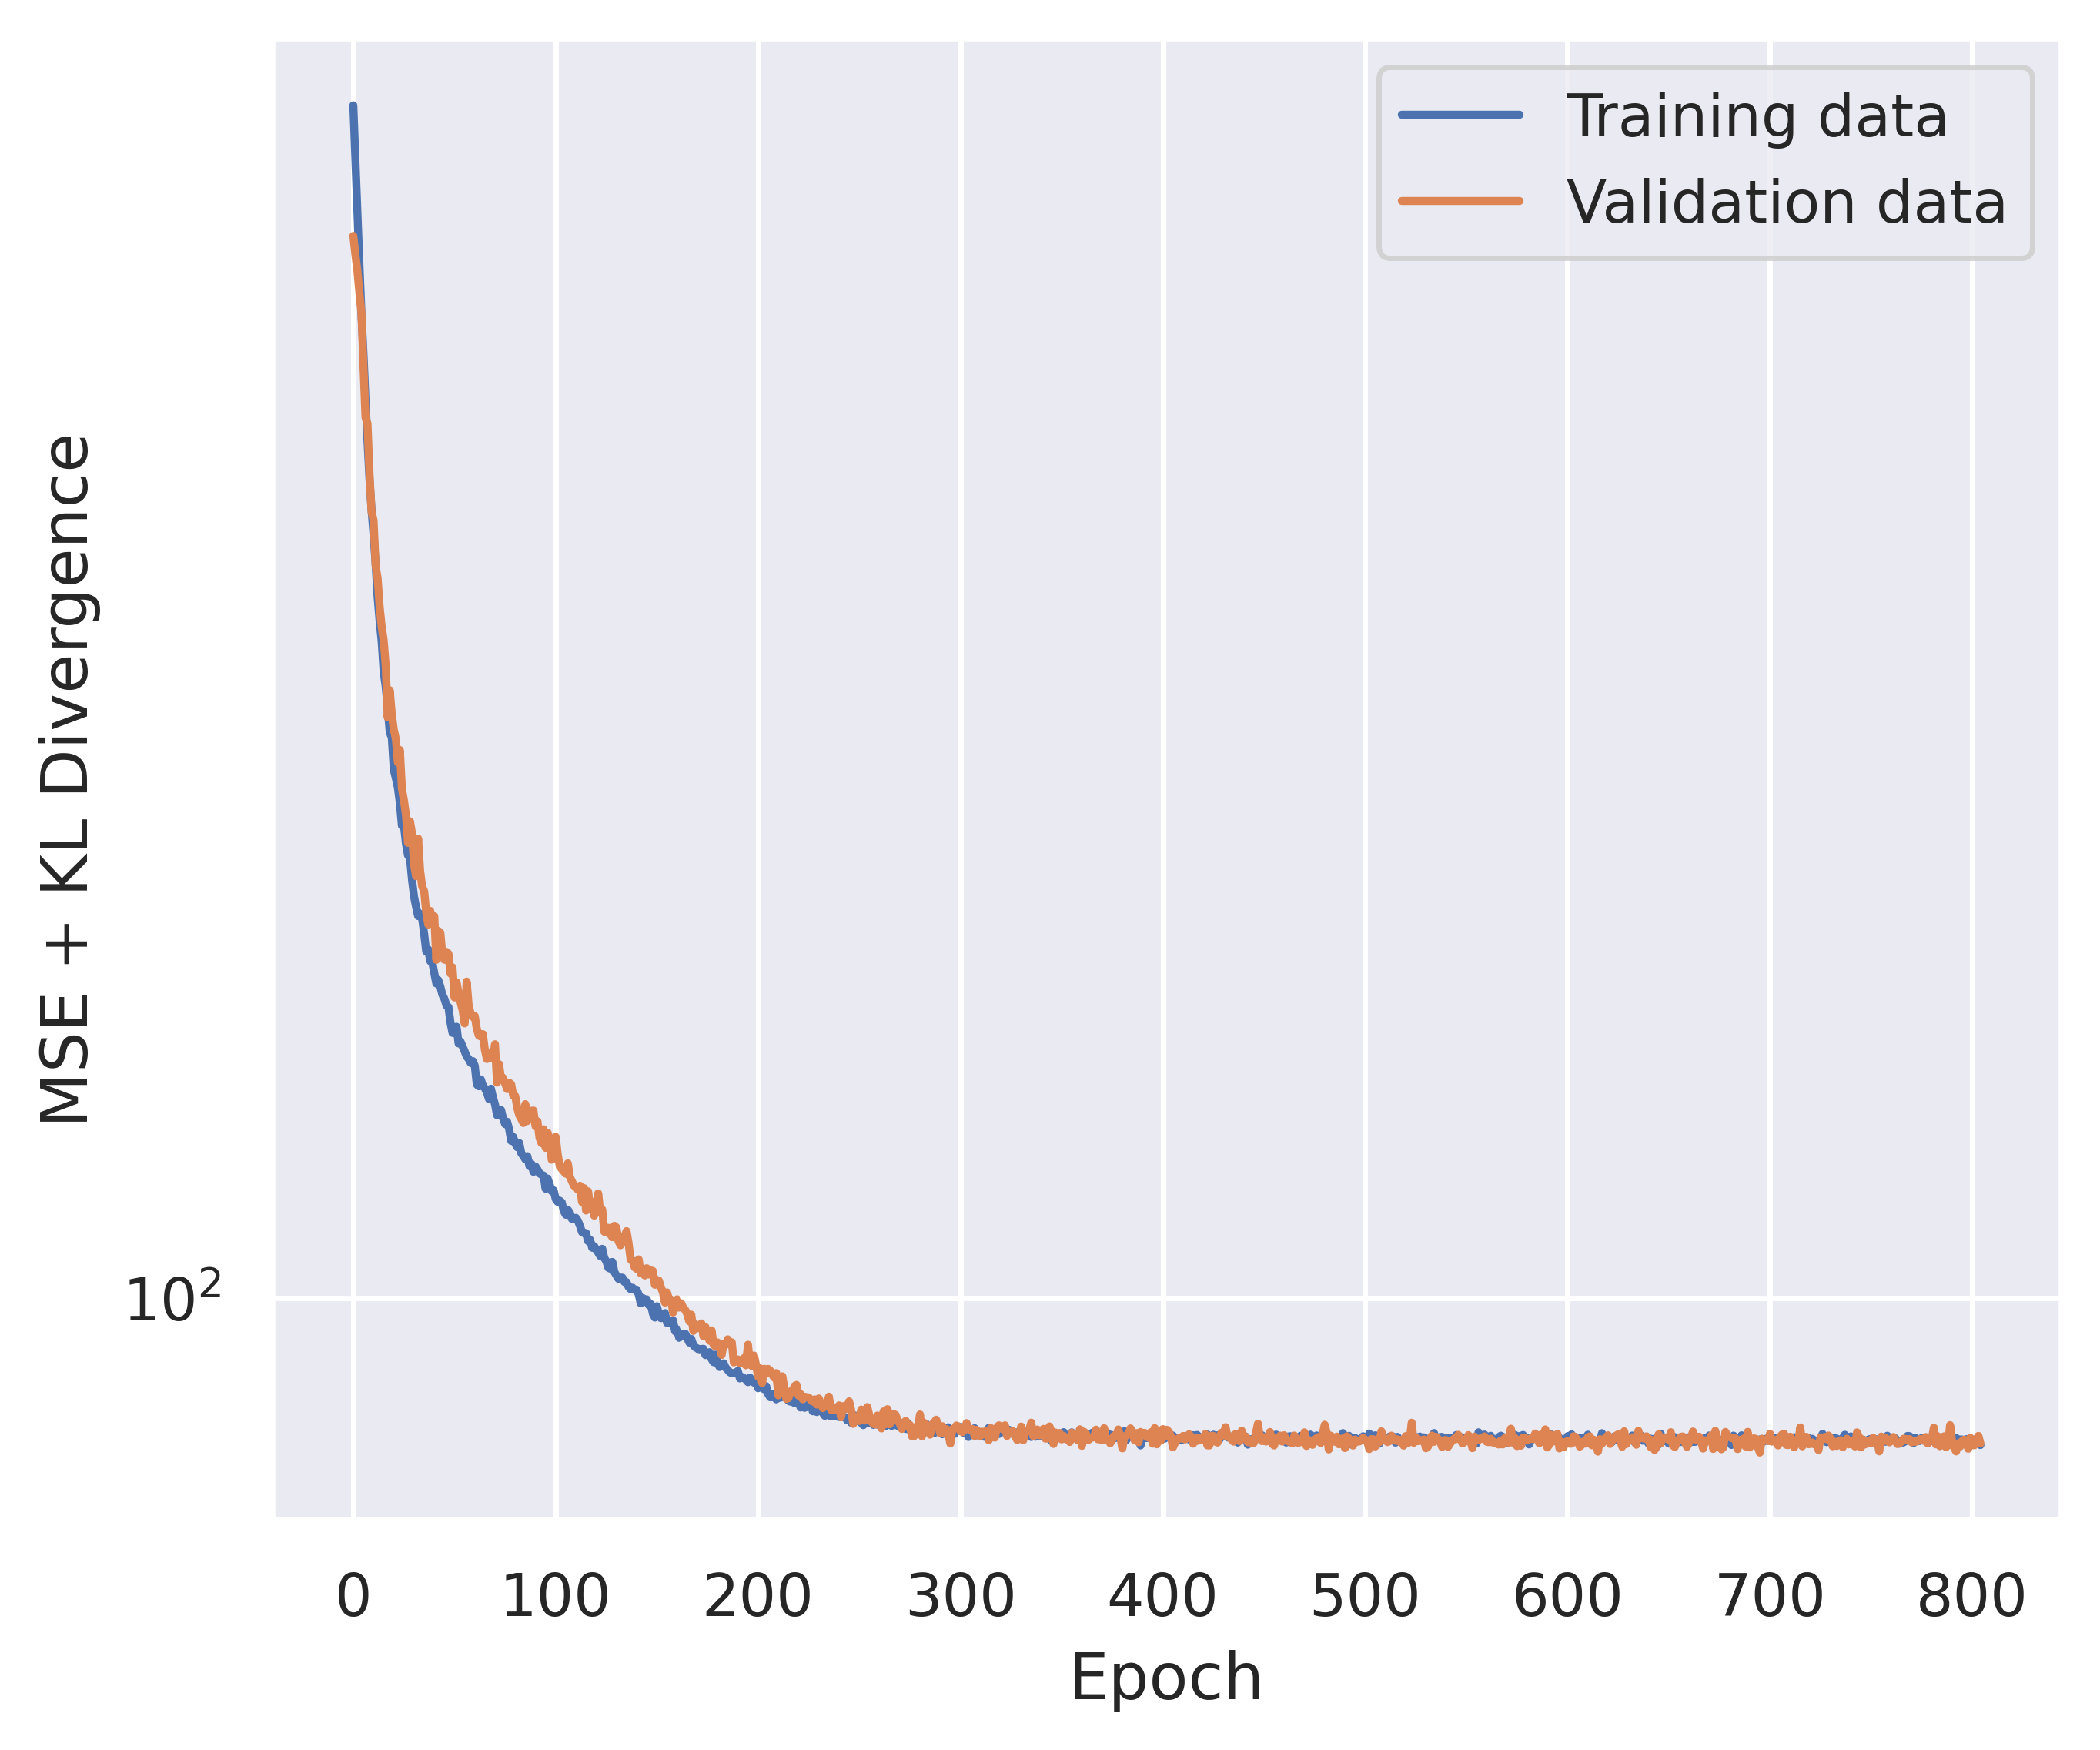

In [13]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [15]:
data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")

In [16]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [17]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,ModelID,AgeCategory,Sex,train_or_test
0,ACH-002016,Adult,Female,train
1,ACH-002459,Adult,Male,train
2,ACH-002084,Adult,Female,train
3,ACH-000911,Adult,Male,train
4,ACH-002243,Adult,Female,train
...,...,...,...,...
907,ACH-001619,Adult,Male,test
908,ACH-001270,Pediatric,Male,test
909,ACH-000878,Adult,Male,test
910,ACH-000563,Adult,Male,test


In [18]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the Model IDs added back in
extracted_col = metadata['ModelID']

latent_df.insert(0, 'ModelID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

29/29 [==============================] - 0s 3ms/step


,ModelID,0,1,2,3,4,5,6,7,8,...,60,61,62,63,64,65,66,67,68,69
0,ACH-002016,-0.439828,-2.233031,-0.178370,1.655007,0.259328,-0.450485,0.995072,0.074680,-0.423606,...,-0.563230,-0.438373,-0.418190,-2.644477,1.455930,-0.403066,-0.769117,0.129130,0.743714,1.711684
1,ACH-002459,0.158604,0.243144,-0.658606,-0.445111,-0.657034,0.158854,0.346306,-0.655014,-0.452882,...,-0.878279,1.103028,-0.960086,-0.686603,0.214484,0.868667,-0.371046,-0.111883,-0.475335,-0.207690
2,ACH-002084,-1.519062,-0.023089,-0.653851,-0.265665,-1.002444,1.000137,0.996671,-0.322029,0.149973,...,-0.387642,0.327359,0.038360,-0.537790,-1.113443,-0.540817,-0.045397,-0.697495,1.116999,-1.161934
3,ACH-000911,1.190972,-1.307682,0.441921,-0.114110,0.513422,-0.029635,-0.687939,0.317180,1.911101,...,1.437817,-0.844636,1.038917,1.419998,0.086976,0.997560,-0.778809,0.918253,1.743394,0.691858
4,ACH-002243,-0.384450,-1.472222,-0.332571,1.590647,-1.839610,0.940015,1.017638,0.546270,0.305431,...,0.702246,1.017452,1.171495,-1.249351,1.031811,-0.254762,0.980637,0.166082,-1.864114,-1.305767


In [19]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-0.034643,-0.018786,0.004884,-0.021371,0.039248,-0.042384,0.032414,0.009567,0.028332,-0.012951,...,0.084094,-0.021814,-0.031163,-0.005313,0.041809,0.015910,0.016175,0.033530,0.023563,0.066336
1,0.030044,0.057998,0.006439,-0.029421,-0.003977,-0.016621,0.021591,-0.019988,-0.063782,-0.045517,...,0.033583,-0.103059,-0.027937,0.012752,0.035559,-0.004912,-0.051767,-0.026627,-0.028017,-0.039394
2,-0.044885,-0.024700,-0.002074,0.011754,-0.042093,0.014245,0.047970,-0.009489,0.011401,-0.057065,...,0.055405,0.004944,-0.051126,0.024678,0.003832,0.008839,-0.028263,0.026857,0.012918,0.028354
3,-0.015553,-0.003088,-0.055477,0.014942,0.029630,0.072798,0.040607,-0.070493,-0.004324,-0.067595,...,0.018114,-0.082460,-0.023459,-0.042566,-0.038063,-0.011956,-0.024815,-0.058613,0.006046,-0.059928
4,0.020240,0.028379,0.008226,0.056760,-0.010616,0.033441,-0.043972,0.062634,-0.037838,-0.007190,...,0.023998,-0.044416,-0.062458,0.005181,0.087309,0.035430,-0.049908,-0.066367,-0.058388,-0.047590


In [20]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,FAM50A,-0.034643,-0.018786,0.004884,-0.021371,0.039248,-0.042384,0.032414,0.009567,0.028332,...,0.084094,-0.021814,-0.031163,-0.005313,0.041809,0.015910,0.016175,0.033530,0.023563,0.066336
1,CDK6,0.030044,0.057998,0.006439,-0.029421,-0.003977,-0.016621,0.021591,-0.019988,-0.063782,...,0.033583,-0.103059,-0.027937,0.012752,0.035559,-0.004912,-0.051767,-0.026627,-0.028017,-0.039394
2,CDAN1,-0.044885,-0.024700,-0.002074,0.011754,-0.042093,0.014245,0.047970,-0.009489,0.011401,...,0.055405,0.004944,-0.051126,0.024678,0.003832,0.008839,-0.028263,0.026857,0.012918,0.028354
3,GPX4,-0.015553,-0.003088,-0.055477,0.014942,0.029630,0.072798,0.040607,-0.070493,-0.004324,...,0.018114,-0.082460,-0.023459,-0.042566,-0.038063,-0.011956,-0.024815,-0.058613,0.006046,-0.059928
4,SEPHS2,0.020240,0.028379,0.008226,0.056760,-0.010616,0.033441,-0.043972,0.062634,-0.037838,...,0.023998,-0.044416,-0.062458,0.005181,0.087309,0.035430,-0.049908,-0.066367,-0.058388,-0.047590
